# Reshaping data for model
### In this file, we will take the data that has been gathered and harmonized and we will fit it, create scenarios, and save it as a structured array for the model. Since we would like to keep the flexibility with excel, we will also save it in an ODYM compatible format and create a file that can do the reverse: if teh excel file is eddited, so is the array. This will be a separate script

In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from seaborn.palettes import color_palette
import xlrd
import pylab
from copy import deepcopy
import logging as log
import xlwt
import tqdm
import math
from scipy.stats import norm
from tqdm import tqdm
from scipy.optimize import curve_fit
import matplotlib
from logistic import logistic as logistic
mpl_logger = log.getLogger("matplotlib")
mpl_logger.setLevel(log.WARNING)  
# For Ipython Notebook only
### Preamble
# Going to parent path
os.getcwd()
os.chdir("..")
os.chdir("..")

# add ODYM module directory to system path, relative
MainPath = os.path.join(os.getcwd(), 'odym', 'modules')
sys.path.insert(0, MainPath)

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))

# Specify path to dynamic stock model and to datafile, relative
DataPath = os.path.join( 'docs', 'files')

# Specify path to dynamic stock model and to datafile, absolute
DataPath = os.path.join(os.getcwd(), 'docs', 'Files')

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

#Read main script parameters
#Load project-specific config file
ProjectSpecs_ConFile = 'ODYM_Config_Vehicle_System.xlsx'
Model_Configfile     = xlrd.open_workbook(os.path.join(DataPath, ProjectSpecs_ConFile))
ScriptConfig         = {'Model Setting': Model_Configfile.sheet_by_name('Config').cell_value(3,3)} # Dictionary with config parameters
Model_Configsheet    = Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario        = Model_Configsheet.cell_value(3,3)
print(Name_Scenario)

#Read control and selection parameters into dictionary
ScriptConfig         = msf.ParseModelControl(Model_Configsheet,ScriptConfig)

Mylog.info('Read and parse config table, including the model index table, from model config sheet.')
IT_Aspects,IT_Description,IT_Dimension,IT_Classification,IT_Selector,IT_IndexLetter,\
PL_Names,PL_Description,PL_Version,PL_IndexStructure,PL_IndexMatch,PL_IndexLayer,\
PrL_Number,PrL_Name,PrL_Comment,PrL_Type,ScriptConfig = msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog)    

class_filename       = 'ODYM_Classifications_Master_Vehicle_System.xlsx'
Classfile            = xlrd.open_workbook(os.path.join(DataPath,class_filename))
Classsheet           = Classfile.sheet_by_name('MAIN_Table')
MasterClassification = msf.ParseClassificationFile_Main(Classsheet,Mylog)


Mylog.info('Define model classifications and select items for model classifications according to information provided by config file.')
ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.error('Item select error for aspect ' + IT_Aspects[m] + ' were found in datafile.')
        break

# Define model index table and parameter dictionary
Mylog.info('### 2.2 - Define model index table and parameter dictionary')
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start + 1

Mylog.info('Define index table dataframe.')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects,  # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           'IndexLetter'   : IT_IndexLetter})  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = pd.Series([len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
                                    index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]


# Define dimension sizes
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)
Nc = len(IndexTable.Classification[IndexTable.index.get_loc('Age-cohort')].Items)
Ng = len(IndexTable.Classification[IndexTable.index.get_loc('Drive_train')].Items)
Ne = len(IndexTable.Classification[IndexTable.index.get_loc('Element')].Items)
Nb = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items)
Ns = len(IndexTable.Classification[IndexTable.index.get_loc('Size')].Items)
Nh = len(IndexTable.Classification[IndexTable.index.get_loc('Recycling_Process')].Items)
NS = len(IndexTable.Classification[IndexTable.index.get_loc('EV_penetration_scenario')].Items)
Na = len(IndexTable.Classification[IndexTable.index.get_loc('Chemistry_Scenarios')].Items)
Nz = len(IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items)
NR = len(IndexTable.Classification[IndexTable.index.get_loc('Reuse_Scenarios')].Items)
NE = len(IndexTable.Classification[IndexTable.index.get_loc('Energy_Storage_Scenarios')].Items)
Nv = len(IndexTable.Classification[IndexTable.index.get_loc('V2G_Scenarios')].Items)

INFO (<ipython-input-1-fe30fc3b3d14> <<module>>): ### 1. - Initialize.
INFO (<ipython-input-1-fe30fc3b3d14> <<module>>): Read and parse config table, including the model index table, from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.
INFO (ODYM_Functions.py <ParseClassificationFile_Main>): End of file or formatting error while reading the classification file in column 16. Check if all classifications are present. If yes, you are good to go!
INFO (<ipython-input-1-fe30fc3b3d14> <<module>>): Define model classifications and select items for model classifications according to information provided by config file.
INFO (<ipython-input-1-fe30fc3b3d14> <<module>

Vehicle stock model for European fleet


In [2]:
# Defining path to raw data
data_path = os.path.join(os.getcwd(), 'data', 'raw_data')
# Importing data
data = pd.read_excel(data_path+'/batteryChemistry_2005_2050.xlsx', sheet_name='Sheet1')
data.tail()

,Battery_Scenarios,Year,LFP,NCA,NCM111,NCM523,NCM622,NCM622-Graphite (Si),NCM811-Graphite (Si),NCM955-Graphite (Si),Li-Sulphur,Li-Air,LMO/NMC,Source,Sum
225,Faraday,2046,0.01,0.11,0.06,0.0,0.0,0.34,0.29,0.19,0.0,0.0,0.0,Faraday institute,1.0
226,Faraday,2047,0.01,0.11,0.06,0.0,0.0,0.34,0.29,0.19,0.0,0.0,0.0,Faraday institute,1.0
227,Faraday,2048,0.01,0.11,0.06,0.0,0.0,0.34,0.29,0.19,0.0,0.0,0.0,Faraday institute,1.0
228,Faraday,2049,0.01,0.11,0.06,0.0,0.0,0.34,0.29,0.19,0.0,0.0,0.0,Faraday institute,1.0
229,Faraday,2050,0.01,0.11,0.06,0.0,0.0,0.34,0.29,0.19,0.0,0.0,0.0,Faraday institute,1.0


In [3]:
# drop irrelevant rows
data.drop(['Source', 'Sum'], axis=1, inplace=True)

### Preparing battery chemistry file per segment

In [4]:
chem = data
chem.keys()

Index(['Battery_Scenarios', 'Year ', 'LFP', 'NCA', 'NCM111', 'NCM523',
       'NCM622', 'NCM622-Graphite (Si)', 'NCM811-Graphite (Si)',
       'NCM955-Graphite (Si)', 'Li-Sulphur', 'Li-Air', 'LMO/NMC'],
      dtype='object')

In [5]:
chem.head()

,Battery_Scenarios,Year,LFP,NCA,NCM111,NCM523,NCM622,NCM622-Graphite (Si),NCM811-Graphite (Si),NCM955-Graphite (Si),Li-Sulphur,Li-Air,LMO/NMC
0,NCX,2005,0.239864,0.191891,0.568245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NCX,2006,0.239864,0.191891,0.568245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NCX,2007,0.239864,0.191891,0.568245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NCX,2008,0.239864,0.191891,0.568245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NCX,2009,0.239864,0.191891,0.568245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
chem.set_index(['Battery_Scenarios', 'Year '])

LFP       NCA    NCM111    NCM523    NCM622  \
Battery_Scenarios Year                                                      
NCX               2005   0.239864  0.191891  0.568245  0.000000  0.000000   
                  2006   0.239864  0.191891  0.568245  0.000000  0.000000   
                  2007   0.239864  0.191891  0.568245  0.000000  0.000000   
                  2008   0.239864  0.191891  0.568245  0.000000  0.000000   
                  2009   0.239864  0.191891  0.568245  0.000000  0.000000   
                  2010   0.141243  0.112994  0.334609  0.411154  0.000000   
                  2011   0.184417  0.161365  0.302744  0.351475  0.000000   
                  2012   0.239712  0.219736  0.257753  0.282799  0.000000   
                  2013   0.294889  0.229358  0.233552  0.242202  0.000000   
                  2014   0.359212  0.220162  0.212410  0.208216  0.000000   
                  2015   0.278930  0.165718  0.288262  0.214975  0.021172   
                  2016   0.313013  0.169449  0.227150  0.212985  0.033390   
                  2017   0.281609  0.151784  0.203269  0.247025  0.051510   
                  2018   0.229903  0.125976  0.179447  0.296560  0.075557   
                  2019   0.275890  0.252501  0.098194  0.192931  0.075720   
                  2020   0.321877  0.379025  0.041225  0.107008  0.060960   
                  2021   0.261227  0.393457  0.043139  0.106531  0.073012   
                  2022   0.200577  0.407889  0.043861  0.101500  0.085770   
                  2023   0.139927  0.422321  0.043390  0.091915  0.099232   
                  2024   0.079277  0.436753  0.041726  0.077776  0.113399   
                  2025   0.018627  0.451185  0.038870  0.059082  0.128271   
                  2026   0.019955  0.438815  0.035235  0.054917  0.130467   
                  2027   0.021284  0.426444  0.031420  0.050530  0.132643   
                  2028   0.022612  0.414073  0.027422  0.045924  0.134799   
                  2029   0.023941  0.401702  0.023244  0.041098  0.136936   
                  2030   0.025022  0.385527  0.018699  0.035699  0.137695   
                  2031   0.025001  0.385195  0.018683  0.035668  0.137577   
                  2032   0.024933  0.384156  0.018633  0.035572  0.137205   
                  2033   0.024840  0.382713  0.018563  0.035438  0.136690   
                  2034   0.024535  0.378024  0.018335  0.035004  0.135015   
...                           ...       ...       ...       ...       ...   
Faraday           2021   0.018268  0.202610  0.209253  0.000000  0.000000   
                  2022   0.016619  0.206078  0.189459  0.000000  0.000000   
                  2023   0.014968  0.209551  0.169636  0.000000  0.000000   
                  2024   0.013314  0.213029  0.149786  0.000000  0.000000   
                  2025   0.011658  0.216512  0.129907  0.000000  0.000000   
                  2026   0.010000  0.220000  0.110000  0.000000  0.000000   
                  2027   0.010000  0.192500  0.097500  0.000000  0.000000   
                  2028   0.010000  0.165000  0.085000  0.000000  0.000000   
                  2029   0.010000  0.137500  0.072500  0.000000  0.000000   
                  2030   0.010000  0.110000  0.060000  0.000000  0.000000   
                  2031   0.010000  0.110000  0.060000  0.000000  0.000000   
                  2032   0.010000  0.110000  0.060000  0.000000  0.000000   
                  2033   0.010000  0.110000  0.060000  0.000000  0.000000   
                  2034   0.010000  0.110000  0.060000  0.000000  0.000000   
                  2035   0.010000  0.110000  0.060000  0.000000  0.000000   
                  2036   0.010000  0.110000  0.060000  0.000000  0.000000   
                  2037   0.010000  0.110000  0.060000  0.000000  0.000000   
                  2038   0.010000  0.110000  0.060000  0.000000  0.000000   
                  2039   0.010000  0.110000  0.060000  0.000000  0.000000   
                  2040   0

In [7]:
chem2 = chem.melt(['Battery_Scenarios', 'Year '])

In [8]:
IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items[9] == 'Li-Air'

False

In [9]:
chem2.head()

,Battery_Scenarios,Year,variable,value
0,NCX,2005,LFP,0.239864
1,NCX,2006,LFP,0.239864
2,NCX,2007,LFP,0.239864
3,NCX,2008,LFP,0.239864
4,NCX,2009,LFP,0.239864


## Adding Roskill chemistry mix for EU

In [10]:
roskill = pd.read_excel('/Users/fernaag/Box/BATMAN/Data/Database/data/01_raw_data/batteryChemistry_EU_Roskill/batteryChemistry_EU_Roskill.xlsx', sheet_name='Treated data')

In [11]:
# Add empty values for the desired years
years = np.arange(2010,2051).astype(int)
df = pd.DataFrame()
for i,j in enumerate(roskill.Chemistry.unique()):
    empty = pd.DataFrame({'Year':years, 'Chemistry': j})
    df = df.append(empty)

In [12]:
# To avoid dropping useful indexes, we will introduce a very small error in roskill years so they can be dopped safely
roskill.Year = roskill.Year.values + 0.0001

In [13]:
df.reset_index(drop=True, inplace=True)

In [14]:
fitted = roskill.append(df, sort=False)

In [15]:
fitted.set_index('Year', inplace=True)

In [16]:
interpol = pd.DataFrame()
for i in fitted.Chemistry.unique():
    fitted[fitted['Chemistry']==i].interpolate(method='index')
    interpol = interpol.append(fitted[fitted['Chemistry']==i].interpolate(method='index'))

In [17]:
interpol.drop(roskill.Year, inplace=True)

In [18]:
interpol.Chemistry.unique()

array(['LNO', 'LFP', 'NCM217', 'NCMA', 'NCM811-Graphite (Si)', 'NiMH',
       'NCM622-Graphite (Si)', 'NCM712-Graphite (Si)'], dtype=object)

In [19]:
# To convert this stacked plot into individual values, we will need to define a code that subracts all values that are below each line to get only the net values
chems = pd.DataFrame()
for j,i in enumerate(interpol.Chemistry.unique()):
    if i == 'LNO':
        chems = chems.append(interpol[interpol['Chemistry']==i]['Stacked value'])
    else:
        chems = chems.append(interpol[interpol['Chemistry']==i]['Stacked value'] -interpol[interpol['Chemistry']==interpol.Chemistry.unique()[j-1]]['Stacked value'])

In [20]:
chemst = chems.reset_index(drop=True)
chems.set_index(interpol.Chemistry.unique(), inplace=True)

In [21]:
chems= chems.reset_index()

In [22]:
chems = chems.melt('index')

In [23]:
chems = chems.rename(columns={'index': 'variable', 'variable':'Year '})

In [24]:
chems['Battery_Scenarios'] = 'Roskill'

In [25]:
chems.head()

,variable,Year,value,Battery_Scenarios
0,LNO,2010,0.002398,Roskill
1,LFP,2010,0.000000,Roskill
2,NCM217,2010,0.000000,Roskill
3,NCMA,2010,0.050360,Roskill
4,NCM811-Graphite (Si),2010,0.038369,Roskill


In [26]:
chem2 = chem2.append(chems, sort=False)

In [27]:
IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items

['LMO/NMC',
 'NCA',
 'LFP',
 'NCM111',
 'NCM217',
 'NCM523',
 'NCM622',
 'NCM622-Graphite (Si)',
 'NCM712-Graphite (Si)',
 'NCM811-Graphite (Si)',
 'NCM955-Graphite (Si)',
 'Li-Air',
 'Li-Sulphur',
 'LNO',
 'NCMA',
 'NiMH',
 'LTO']

In [28]:
chem2.variable.unique()

array(['LFP', 'NCA', 'NCM111', 'NCM523', 'NCM622', 'NCM622-Graphite (Si)',
       'NCM811-Graphite (Si)', 'NCM955-Graphite (Si)', 'Li-Sulphur',
       'Li-Air', 'LMO/NMC', 'LNO', 'NCM217', 'NCMA', 'NiMH',
       'NCM712-Graphite (Si)'], dtype=object)

In [29]:
# Assming PHEVs have the same battery chemistry scenarios as BEVs
ChemArray = np.zeros((Na,Ng,Nb,Nt))
for s in range(10):
    for m in range(0, len(chem2.Battery_Scenarios.values)):
        ScenarioPosition = IndexTable.Classification[IndexTable.index.get_loc('Chemistry_Scenarios')].Items.index(chem2.Battery_Scenarios.values[m])
        ChemistryPosition= IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items.index(chem2.variable.values[m])
        Timeposition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(chem2['Year '].values[m])
        ChemArray[ScenarioPosition, 1, ChemistryPosition, Timeposition] = chem2.value.values[m]
        ChemArray[ScenarioPosition, 3, ChemistryPosition, Timeposition] = chem2.value.values[m]

In [30]:
results_path = os.path.join(os.getcwd(), 'data', 'scenario_data')
np.save(results_path+'/battery_chemistries', ChemArray)


In [31]:
IndexTable.Classification[IndexTable.index.get_loc('Chemistry_Scenarios')].Items

['NCX', 'LFP', 'Next_gen', 'Roskill', 'BNEF', 'Faraday']

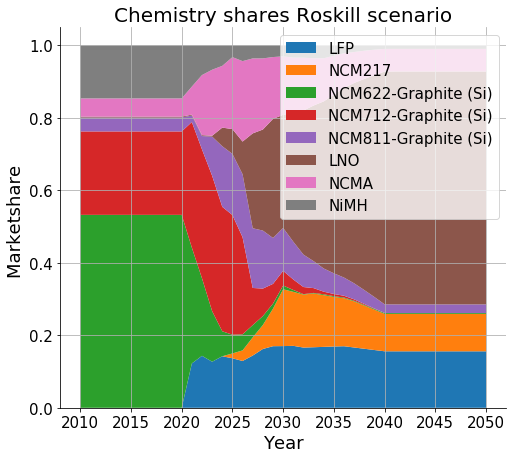

In [35]:
fig, ax = plt.subplots(figsize=(8,7)) ### The legend is wrong
s = 3
ax.stackplot(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items[60:], 
        [ChemArray[s,1,i,60:] for i in np.einsum('bt->b', ChemArray[s,1,:60:]).nonzero()[0].tolist()])
ax.set_ylabel('Marketshare ',fontsize =18)
right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)
plt.grid()
ax.legend([IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items[i] for i in np.einsum('bt->b', ChemArray[s,1,:,70:]).nonzero()[0].tolist()], loc='upper right',prop={'size':15})
ax.set_title('Chemistry shares {} scenario'.format(IndexTable.Classification[IndexTable.index.get_loc('Chemistry_Scenarios')].Items[s]), fontsize=20)
ax.set_xlabel('Year',fontsize =18)
ax.tick_params(axis='both', which='major', labelsize=15)